<a href="https://colab.research.google.com/github/RenataKostolina/DLS/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import gdown
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
import gc
import tqdm
from torchvision import transforms
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
# Download some attributes

!gdown --id 1utdTz3TY2LyqoRHzZJVVeiku44pacQ0Y

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1utdTz3TY2LyqoRHzZJVVeiku44pacQ0Y
To: /content/lfw_attributes.txt
100% 14.9M/14.9M [00:00<00:00, 39.3MB/s]


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_data, val_data = train_test_split(data, train_size=0.9, shuffle=False)

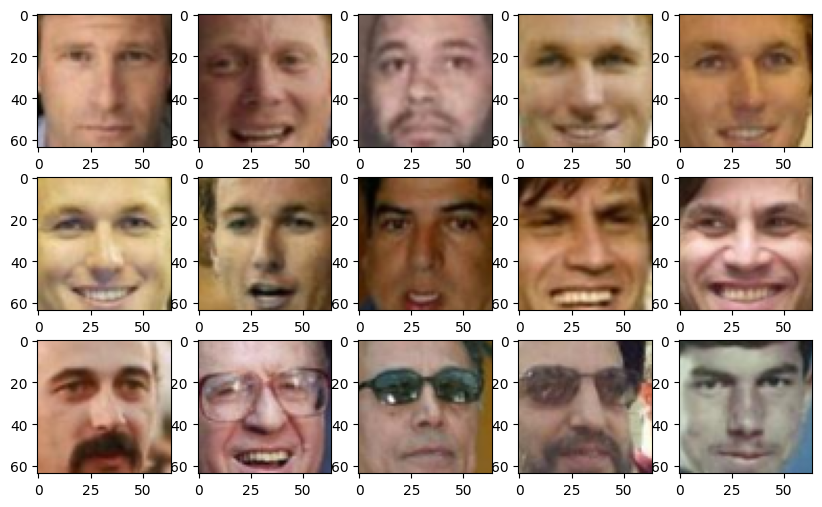

In [ ]:
fig, ax = plt.subplots(3, 5, figsize = (10, 6))
for i, im in enumerate(ax.flatten()):
  im.imshow(train_data[i])

In [ ]:
train_loader = torch.utils.data.DataLoader(torch.Tensor(train_data.swapaxes(1,3).swapaxes(2,3)), batch_size = 32, shuffle=True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(torch.Tensor(val_data.swapaxes(1,3).swapaxes(2,3)), batch_size = 32, shuffle=False, num_workers = 2)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.

напомню, что автоэнкодер выглядит вот так:

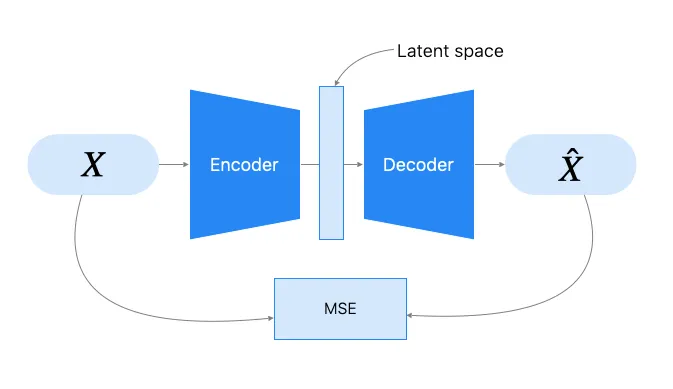

In [ ]:
dim_code = 256 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(64),

            nn.Flatten(),
            nn.Linear(4*4*64, dim_code)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 4*4*64),
            nn.Unflatten(1, (64, 4, 4)),

            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, stride = 2, kernel_size=3, padding=0),

            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, stride = 2, kernel_size=3, padding=1),

            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, stride = 2, kernel_size=3, padding=2, output_padding=0),

            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, stride = 2, kernel_size=3, padding=0, output_padding=1),
            nn.Sigmoid()
            )

        # Обратите внимание на формат, в котором функция fetch() возвращает data

    def forward(self, x):
      latent_code = self.encoder(x)
      reconstruction = self.decoder(latent_code)
      return reconstruction, latent_code

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def fit_epoch(model, optimizer, criterion, train_data):
    model.train()
    running_loss = 0.0
    for inputs in train_data:
        inputs = inputs.to(device)
        optimizer.zero_grad()

        reconstruction, latent_space = model(inputs)
        loss = criterion(reconstruction, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.cpu().item()

    train_loss = running_loss / len(train_data)
    return train_loss

In [ ]:
def val_epoch(model, criterion, val_data):
    model.eval()
    running_loss = 0.0

    for inputs in val_data:
        inputs = inputs.to(device)

        with torch.set_grad_enabled(False):
            reconstruction, latent_space = model(inputs)
            loss = criterion(reconstruction, inputs)

        running_loss += loss.cpu().item()
    val_loss = running_loss / len(val_data)
    return val_loss

In [ ]:
def show_iter(model, val_data, num):
    val = next(iter(val_data))
    model.eval()
    with torch.no_grad():
        reconstruction, latent_space = autoencoder(val.to(device))
        reconstruction = reconstruction.permute(0, 3, 2, 1).permute(0, 2, 1, 3).cpu().detach().numpy()
    val = val.permute(0, 3, 2, 1).permute(0, 2, 1, 3).cpu().detach().numpy()
    for i in range(num):
        plt.subplot(num, 2, 2*i+1)
        plt.imshow(val[i])
        plt.axis('off')
        plt.title(f"Original {i}")

        plt.subplot(num, 2, 2*i+2)
        plt.imshow(reconstruction[i])
        plt.axis('off')
        plt.title(f"Reconstruct {i}")

In [ ]:
def train(model, criterion, optimizer, scheduler, train_data, val_data, epochs):
    history = {'epoch':[],'train_loss':[], 'val_loss':[]}
    gc.collect()
    torch.cuda.empty_cache()
    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}")
        train_loss = fit_epoch(model, optimizer, criterion, train_data)
        val_loss = val_epoch(model, criterion, val_data)
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        scheduler.step()
    print('Done!')
    return history

In [ ]:
def res_history(history):
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.plot(history['epoch'], history['train_loss'], label='train_loss')
    axes.plot(history['epoch'], history['val_loss'], label='val_loss')
    axes.legend()
    print(f"Train loss: {history['train_loss'][-1]:.4f}")
    print(f"Validation loss: {history['val_loss'][-1]:.4f}")

In [ ]:
criterion = nn.BCELoss()
autoencoder = Autoencoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)
epochs = 20

In [ ]:
history = train(autoencoder, criterion, optimizer, scheduler, train_loader, val_loader, epochs)

Epoch 0/20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Done!


Train loss: 0.6015
Validation loss: 0.6005


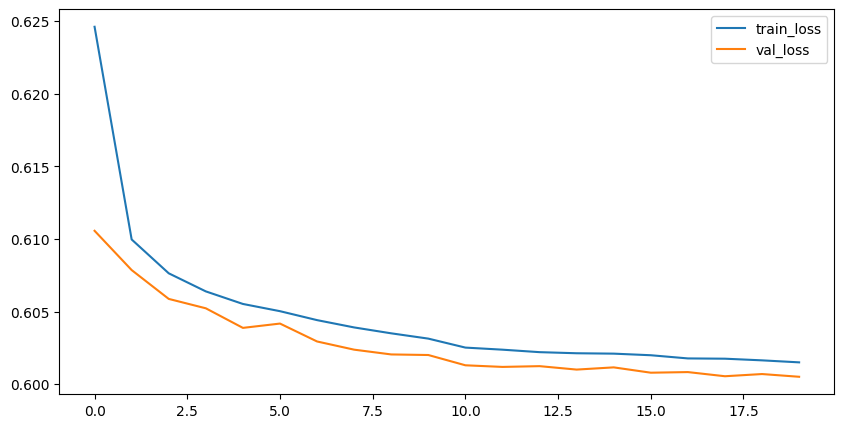

In [ ]:
res_history(history)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

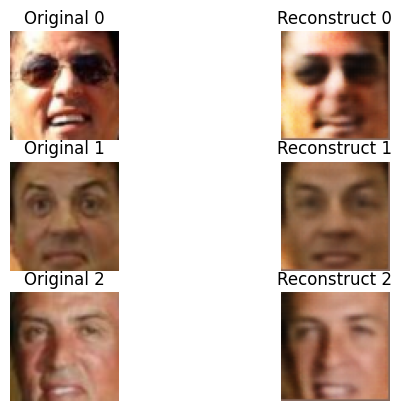

In [ ]:
show_iter(autoencoder, val_loader, 3)

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

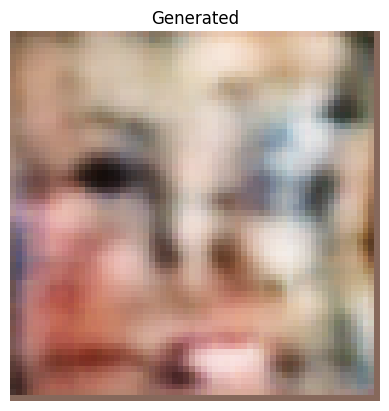

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.array([np.random.normal(1, 4, dim_code) for i in range(10)])
autoencoder.eval()
with torch.no_grad():
  output = autoencoder.decoder(torch.tensor(z, dtype = torch.float32).to(device))
  output = output.permute(0, 3, 2, 1).permute(0, 2, 1, 3).cpu().detach().numpy()
  plt.subplot(1, 1, 1)
  plt.imshow(output[6])
  plt.axis('off')
  plt.title(f"Generated")


In [ ]:
# Рискну предположить, что модель имеет слишком большое пространство признаков, поэтому получается каша

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
dataframe = pd.DataFrame(data=attrs)
dataframe.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [ ]:
smile = dataframe.sort_values('Smiling', ascending=False)[0:15]
smile_idx = smile.index

In [ ]:
sad = dataframe.sort_values('Smiling')[0:15]
sad_idx = sad.index

In [ ]:
smile_data = data[smile_idx]
sad_data = data[sad_idx]

In [ ]:
smile_data = torch.Tensor(smile_data.swapaxes(1,3).swapaxes(2,3))
sad_data = torch.Tensor(sad_data.swapaxes(1,3).swapaxes(2,3))

In [ ]:
autoencoder.eval()
with torch.no_grad():
    rec, lat_smile = autoencoder(smile_data.to(device))
    rec, lat_sad = autoencoder(sad_data.to(device))

In [ ]:
smile_vect = lat_smile - lat_sad
smile_vect = smile_vect.mean(dim=0)

In [ ]:
def smiling(model, data):
  model.eval()
  with torch.no_grad():
    lat_orig = autoencoder.encoder(data.to(device))
    lat_smile = lat_orig + smile_vect.to(device)
    rec_smile = autoencoder.decoder(lat_smile).view(-1, 3, 64, 64)
    return rec_smile

In [ ]:
smiled_data = smiling(autoencoder, sad_data.to(device))

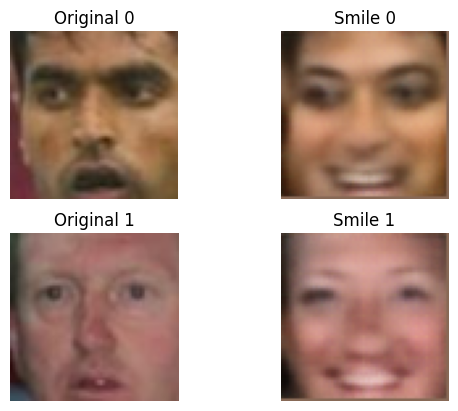

In [ ]:
generated_data = smiled_data.permute(0, 3, 2, 1).permute(0, 2, 1, 3).cpu().detach().numpy()
original_data = sad_data.permute(0, 3, 2, 1).permute(0, 2, 1, 3).cpu().detach().numpy()
for i in range(2):
    plt.subplot(2, 2, 2*i+1)
    plt.imshow(original_data[i])
    plt.axis('off')
    plt.title(f"Original {i}")

    plt.subplot(2, 2, 2*i+2)
    plt.imshow(generated_data[i])
    plt.axis('off')
    plt.title(f"Smile {i}")

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.33MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
dim_code = 15

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),

            nn.Conv2d(8, 16, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(32),

            nn.Flatten(),
            nn.Linear(7*7*32, dim_code*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 7*7*32),
            nn.Unflatten(1, (32, 7, 7)),

            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, stride = 2, kernel_size=3, padding=3, output_padding =1),

            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, stride = 2, kernel_size=3, padding=3, output_padding=1),

            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, stride = 2, kernel_size=3, padding=3, output_padding=1),
            nn.Sigmoid()
            )


    def encode(self, x):
        x = self.encoder(x).view(-1, 2, dim_code)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
def fit_epoch_vae(model, optimizer, criterion, train_data):
    model.train()
    running_loss = 0.0
    for inputs, _ in train_data:
        inputs = inputs.to(device)
        optimizer.zero_grad()

        mu, logsigma, reconstruction = model(inputs)
        loss = criterion(inputs, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()

        running_loss += loss.cpu().item()

    train_loss = running_loss / len(train_data)
    return train_loss

In [ ]:
def val_epoch_vae(model, criterion, val_data):
    model.eval()
    running_loss = 0.0

    for inputs, _ in val_data:
        inputs = inputs.to(device)

        with torch.set_grad_enabled(False):
            mu, logsigma, reconstruction = model(inputs)
            loss = criterion(inputs, mu, logsigma, reconstruction)

        running_loss += loss.cpu().item()
    val_loss = running_loss / len(val_data)
    return val_loss

In [ ]:
def train_vae(model, criterion, optimizer, scheduler, train_data, val_data, epochs):
    history = {'epoch':[],'train_loss':[], 'val_loss':[]}
    gc.collect()
    torch.cuda.empty_cache()
    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}")
        train_loss = fit_epoch_vae(model, optimizer, criterion, train_data)
        val_loss = val_epoch_vae(model, criterion, val_data)
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        scheduler.step()
    print('Done!')
    return history

И обучим модель:

In [ ]:
criterion = loss_vae
autoencoder = VAE().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)
epochs = 20

In [ ]:
history = train_vae(autoencoder, criterion, optimizer, scheduler, train_loader, test_loader, epochs)

Epoch 0/20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Done!


Train loss: 3423.0970
Validation loss: 3238.6137


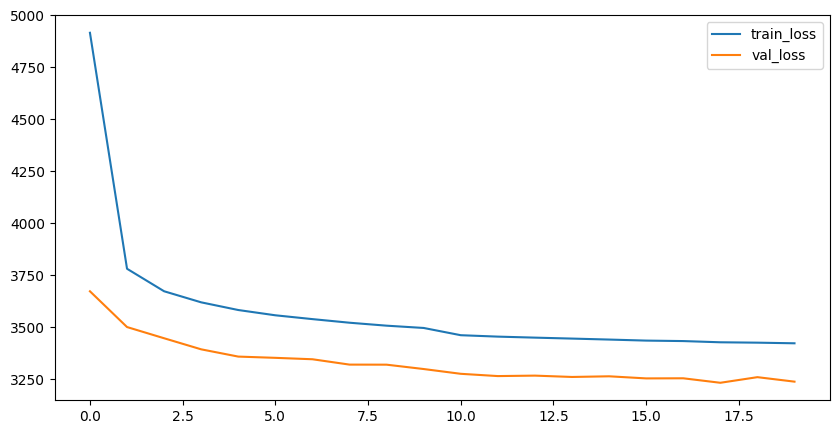

In [ ]:
res_history(history)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
val = next(iter(test_loader))[0]
autoencoder.eval()
with torch.no_grad():
    mu, logsigma, reconstruction = autoencoder(val.to(device))

Text(0.5, 1.0, 'Reconstruct')

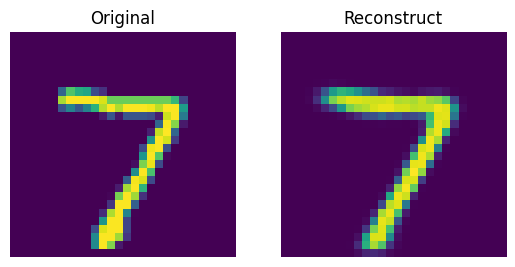

In [ ]:
val = val.cpu().detach().squeeze()[0]
reconstruction = reconstruction.cpu().detach().squeeze()[0]
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(val)
plt.axis('off')
plt.title(f"Original")

plt.subplot(1, 2, 2)
plt.imshow(reconstruction)
plt.axis('off')
plt.title(f"Reconstruct")

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

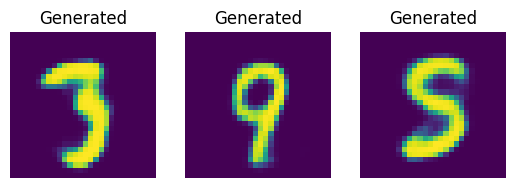

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, dim_code) for i in range(10)])
autoencoder.eval()
for i in range(3):
  z = np.array([np.random.normal(0, 1, dim_code)])
  with torch.no_grad():
    output = autoencoder.decode(torch.tensor(z, dtype = torch.float32).to(device))
    output = output.cpu().detach().squeeze()
    plt.subplot(1, 3, i+1)
    plt.imshow(output)
    plt.axis('off')
    plt.title(f"Generated")

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
autoencoder.eval()
lat = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        mu, logsigma = autoencoder.encode(inputs)
        z = autoencoder.gaussian_sampler(mu, logsigma)
        z = z.cpu().detach().numpy()
        lat.append(z)
lat = np.vstack(lat)

In [ ]:
tsne = TSNE()
pred = tsne.fit_transform(lat)

<Axes: >

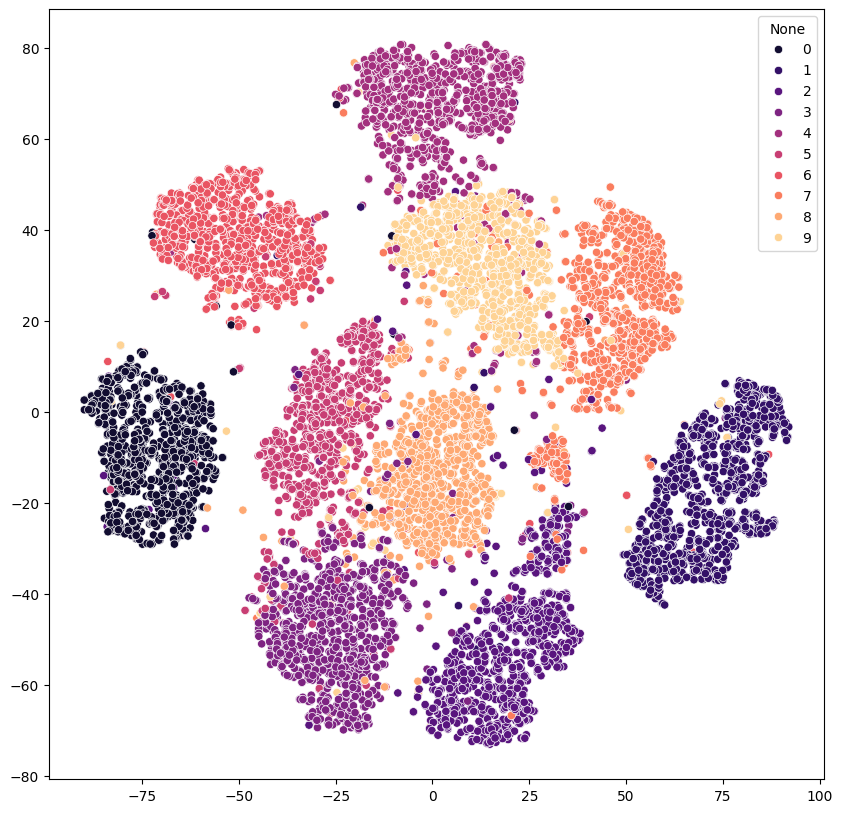

In [ ]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = pred[:, 0], y = pred[:, 1], hue = test_dataset.targets, palette=sns.color_palette('magma', 10))

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
dim_code = 10

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28 + 10, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),

            nn.Linear(500, 300),
            nn.ReLU(),
            nn.BatchNorm1d(300),

            nn.Linear(300, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),

            nn.Linear(100, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),

            nn.Linear(50, dim_code*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code + 10, 50),

            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, 100),

            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 300),

            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Linear(300, 500),

            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 28*28),

            nn.Unflatten(1, (1, 28,28)),
            nn.Sigmoid()
            )

    def encode(self, x, class_num):
        x = torch.flatten(x, start_dim = 1)
        x = torch.cat([x, class_num], dim = 1)
        x = self.encoder(x).view(-1, 2, dim_code)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu

    def decode(self, z, class_num):
        z = torch.cat([z, class_num], dim = 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [ ]:
def fit_epoch_cvae(model, optimizer, criterion, train_data):
    model.train()
    running_loss = 0.0
    for inputs, class_num in train_data:
        inputs = inputs.to(device)
        class_num = F.one_hot(class_num, 10)
        class_num = class_num.to(device)
        optimizer.zero_grad()

        mu, logsigma, reconstruction = model(inputs, class_num)
        loss = criterion(inputs, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()

        running_loss += loss.cpu().item()

    train_loss = running_loss / len(train_data)
    return train_loss

In [ ]:
def val_epoch_cvae(model, criterion, val_data):
    model.eval()
    running_loss = 0.0

    for inputs, class_num in val_data:
        inputs = inputs.to(device)
        class_num = F.one_hot(class_num, 10)
        class_num = class_num.to(device)

        with torch.set_grad_enabled(False):
            mu, logsigma, reconstruction = model(inputs, class_num)
            loss = criterion(inputs, mu, logsigma, reconstruction)

        running_loss += loss.cpu().item()
    val_loss = running_loss / len(val_data)
    return val_loss

In [ ]:
def train_cvae(model, criterion, optimizer, scheduler, train_data, val_data, epochs):
    history = {'epoch':[],'train_loss':[], 'val_loss':[]}
    gc.collect()
    torch.cuda.empty_cache()
    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}")
        train_loss = fit_epoch_cvae(model, optimizer, criterion, train_data)
        val_loss = val_epoch_cvae(model, criterion, val_data)
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        scheduler.step()
    print('Done!')
    return history

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
criterion = loss_vae
autoencoder = CVAE().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)
epochs = 20

In [ ]:
history = train_cvae(autoencoder, criterion, optimizer, scheduler, train_loader, test_loader, epochs)

Epoch 0/20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Done!


Train loss: 3419.6014
Validation loss: 3148.5373


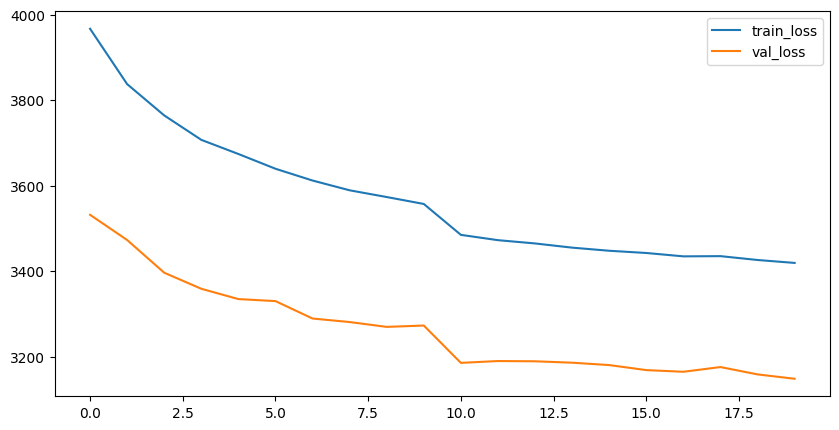

In [ ]:
res_history(history)

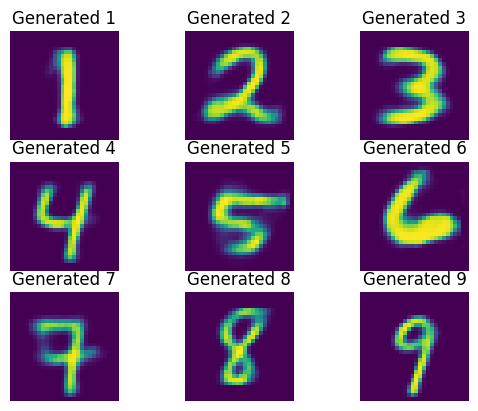

In [ ]:
z = torch.tensor(range(10), dtype = torch.int64)
z = z.to(device)
z = F.one_hot(z, 10)
autoencoder.eval()
with torch.no_grad():
  lat = np.array([np.random.normal(0, 1, dim_code) for i in range(10)])
  lat = torch.tensor(lat, dtype = torch.float32).to(device)
  output = autoencoder.decode(lat, z.to(device))
  output = output.cpu().detach().squeeze()
  for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.imshow(output[i+1])
    plt.axis('off')
    plt.title(f"Generated {i+1}")

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
autoencoder.eval()
lat = []
with torch.no_grad():
    for inputs, class_num in test_loader:
        inputs = inputs.to(device)
        class_num = F.one_hot(class_num, 10)
        class_num = class_num.to(device)
        mu, logsigma, class_num = autoencoder.encode(inputs, class_num)
        z = autoencoder.gaussian_sampler(mu, logsigma)
        z = z.cpu().detach().numpy()
        lat.append(z)
lat = np.vstack(lat)

In [ ]:
tsne = TSNE()
pred = tsne.fit_transform(lat)

<Axes: >

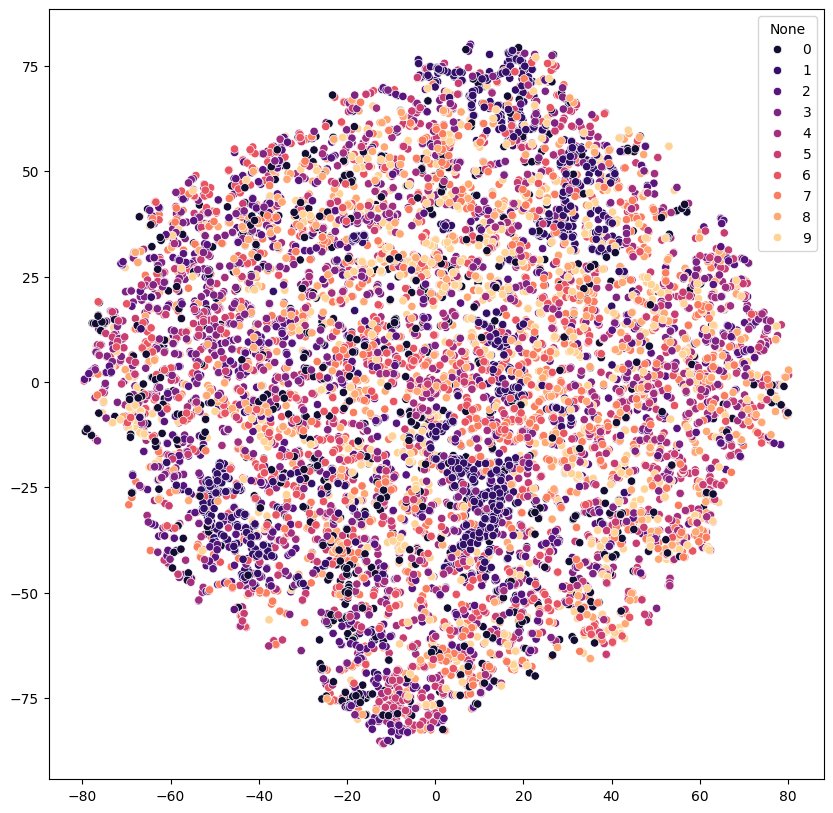

In [ ]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = pred[:, 0], y = pred[:, 1], hue = test_dataset.targets, palette=sns.color_palette('magma', 10))

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Сомнительно, но окэй